In [12]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

In [13]:
data = pd.read_csv("GVA_w-injury_2015_2021apr_geocoded.csv")
data = data.rename(columns={"X": "longitude", "Y": "latitude"})

data['n_killed'] = data['n_killed'].fillna(0)
data['n_injured'] = data['n_injured'].fillna(0)

data = data.drop(columns=['state', 'city_or_county', 'address', 'incident_url', 'source_url'])

In [14]:
gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data.longitude, data.latitude),
    crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=3857)

coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
tree = cKDTree(coords)

distances, indices = tree.query(coords, k=2)
gdf['dist_to_nearest'] = distances[:, 1]

buffer_radius = 2000

In [15]:
neighbors_indices = tree.query_ball_point(coords, r=buffer_radius)

gdf['count_2km'] = [len(inds)-1 for inds in neighbors_indices]

In [16]:
mean_killed = []
mean_injured = []
for i, inds in enumerate(neighbors_indices):
    inds = [j for j in inds if j != i]
    if inds:
        mean_killed.append(gdf.iloc[inds]['n_killed'].mean())
        mean_injured.append(gdf.iloc[inds]['n_injured'].mean())
    else:
        mean_killed.append(0)
        mean_injured.append(0)

gdf['mean_killed_2km'] = mean_killed
gdf['mean_injured_2km'] = mean_injured

In [17]:
feature_cols = ['latitude', 'longitude', 'month', 'year', 'dist_to_nearest', 
                'count_2km', 'mean_killed_2km', 'mean_injured_2km']

X = gdf[feature_cols].fillna(0)
y = gdf[['n_killed','n_injured']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=53)

In [18]:
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    n_jobs=-1,
    random_state=42
)

model = MultiOutputRegressor(xgb_model)
model.fit(X_train, y_train)

,estimator,"XGBRegressor(...ree=None, ...)"
,n_jobs,None
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None


In [19]:
preds = model.predict(X_val)
mae_killed = mean_absolute_error(y_val['n_killed'], preds[:,0])
mae_injured = mean_absolute_error(y_val['n_injured'], preds[:,1])

print("MAE Killed:", mae_killed)
print("MAE Injured:", mae_injured)

MAE Killed: 0.4845520257949829
MAE Injured: 0.5111332535743713


In [20]:
model.fit(X, y)

full_preds = model.predict(X)
gdf['pred_killed'] = full_preds[:,0]
gdf['pred_injured'] = full_preds[:,1]

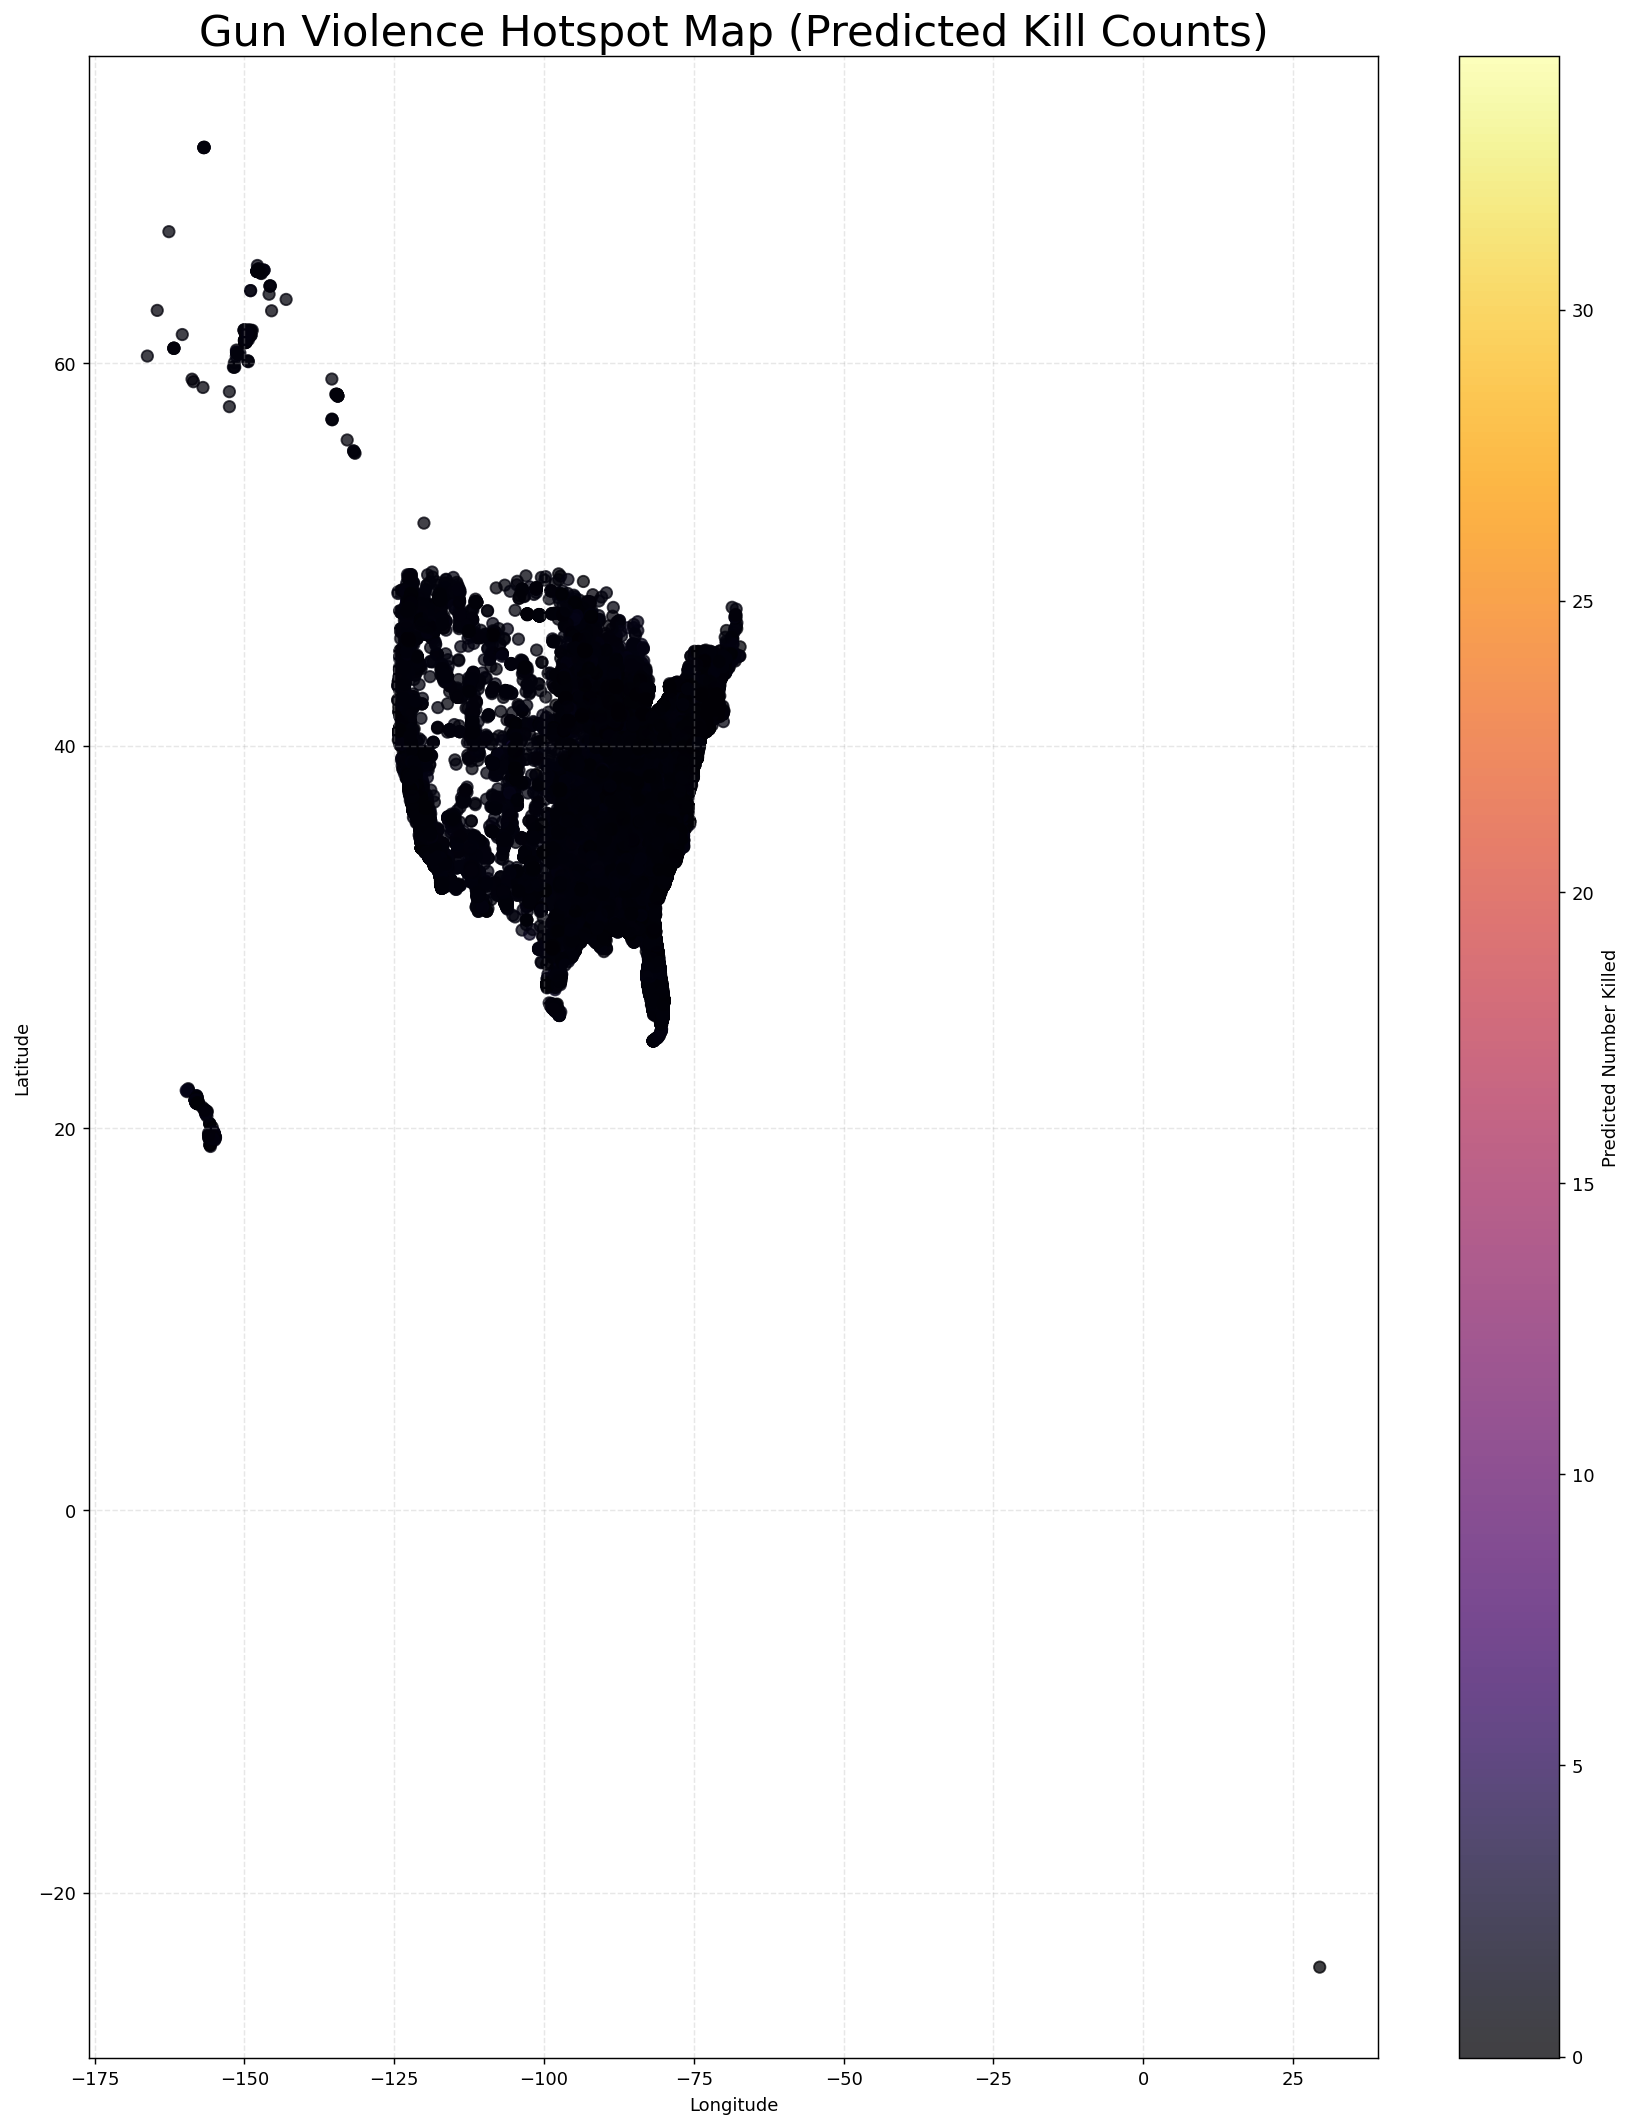

In [ ]:
gdf_plot = gdf.to_crs(epsg=4326)

plt.figure(figsize=(16,20), dpi=130)

plt.scatter(
    gdf_plot.geometry.x, 
    gdf_plot.geometry.y,
    c=gdf['pred_killed'],
    cmap='inferno',
    s=40,
    alpha=0.75
)

plt.gca().set_aspect('auto')#https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_aspect.html

plt.colorbar(label='Predicted Number Killed')
plt.title('Gun Violence Hotspot Map (Predicted Kill Counts)', fontsize=24)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

